# SAR processing on Sentinel-1 images

## Introduction to SAR image processing

## Description

**Summary**

The following exercise is an introduction to processing and analysis of SAR images using the
ORFEO ToolBox.
There are also a lot of other open source tools to process SAR images that can be used in combination
with OTB (see PolSARPro, Sentinel-1 toolbox. . . )

**Prerequisites**

* Installed Monteverdi and Orfeo ToolBox software
* Downloaded data
* Understandig of Orfeo Toolbox applications (see relevant exercise)

**Goals**

* SAR image manipulation
* Radiometric calibration
* Geometric corrections
* Speckle filtering
* Basic SAR polarimetry

### Steps

#### Data

located in `WorkshopData/sar` folder.

#### Introduction to SAR imagery 

In this exercise we will use an extract from a Sentinel-1 SLC Strip Map
(80 km Swath, 5 x 5 m spatial resolution): s1_hh.tif et s1_hv.tif. The image is located in Germany
near the Constance lake (47.456276, 9.638616).

##### Question 1

Analyze the image. How many bands are present in each image?



In [16]:
!echo WorkshopData/sar/s1_hh.tif ; echo ; gdalinfo -hist WorkshopData/sar/s1_hh.tif 2> log ; \
    echo "*****" ; \
    echo WorkshopData/sar/s1_hv.tif ; echo ; gdalinfo -hist WorkshopData/sar/s1_hv.tif 2> log ;

WorkshopData/sar/s1_hh.tif

Driver: GTiff/GeoTIFF
Files: WorkshopData/sar/s1_hh.tif
       WorkshopData/sar/s1_hh.tif.ovr
       WorkshopData/sar/s1_hh.tif.aux.xml
Size is 4000, 4000
Coordinate System is `'
Origin = (11500.000000000000000,32100.000000000000000)
Pixel Size = (1.000000000000000,1.000000000000000)
Metadata:
  TIFFTAG_DATETIME=2015:08:11 08:07:42
  TIFFTAG_IMAGEDESCRIPTION=Sentinel-1A SM SLC L1
  TIFFTAG_SOFTWARE=Sentinel-1 IPF 002.53
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (   11500.000,   32100.000) 
Lower Left  (   11500.000,   36100.000) 
Upper Right (   15500.000,   32100.000) 
Lower Right (   15500.000,   36100.000) 
Center      (   13500.000,   34100.000) 
Band 1 Block=4000x1 Type=Int16, ColorInterp=Gray
  256 buckets from -63.2118 to 45.2118:
  652255 0 25156 0 0 25975 0 27335 0 28446 0 0 30131 0 31058 0 0 32514 0 33954 0 35610 0 0 37020 0 39129 0 40443 0 0 41907 0 44074 0 46358 0 0 48554 0 50928 0 0 52805 0 55145 0 56996 0 0 60

##### Solution 1

The 2 extracts correspond to polarimetric combinations HH (for horizontal transmission and horizontal reception) and HV (for horizontal transmission and vertical reception).

##### Question 2

What do these bands correspond to in the complex product?

##### Solution 2

The 2 bands correspond to the real and the imaginary parts of the complex signal.

##### Queston 3

Compute the image intensity of the complex products s1_hh.tif and s1_hv.tif. Compute also the image intensity in decibels (dB).

We can use the BandMath application to compute the image intensity:

For HH:


In [19]:
!otbcli_BandMath \
    -il WorkshopData/sar/s1_hh.tif \
    -out intensity_hh.tif int32 \
    -exp "im1b1*im1b1+im1b2*im1b2"

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2022-06-23 16:26:38 (INFO): Loading kwl metadata from attached geom file WorkshopData/sar/s1_hh.geom
2022-06-23 16:26:38 (INFO): Default RAM limit for OTB 

For HV:


In [20]:
!otbcli_BandMath \
    -il WorkshopData/sar/s1_hv.tif \
    -out intensity_hh.tif int32 \
    -exp "im1b1*im1b1+im1b2*im1b2"

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2022-06-23 16:27:16 (INFO): Loading kwl metadata from attached geom file WorkshopData/sar/s1_hv.geom
2022-06-23 16:27:16 (INFO): Default RAM limit for OTB 


#### Radiometric calibration 

SAR images, like this Sentinel-1 product, provide pixel values without units
(radar reflectivity or radar brightness). These are called digital numbers (DN).

Image metadata allows to transform DN into physical values (in case of SAR backscattering coefficient)
which allows to compare images from different sensors or acquired at different dates in order to perform
analysis.

SAR calibration consists in computing one of the following physical magnitudes:

* β0: radar brightness coefficient, the reflectivity per unit area in slant range which is dimensionless.
* σ0: radar backscatter (ratio of the outgoing radar signal that the target redirects back towards the
antenna).
* γ0: backscatter normalized by the incidence angle.

For Sentinel-1, Look Up Tables available in image metadata allow to convert DN into those values.
ORFEO ToolBox will retrieve these values automatically and compute the backscattering coeficient.

1. Find the application which allows to perform this operation with OTB
2. Compute γ0 for HH and HV images.
3. Convert in decibels (dB).




In the case of Sentinel-1, calibration coefficients are directly read in the product metadata



In [26]:
!otbcli_SARCalibration \
    -in WorkshopData/sar/s1_hh.tif \
    -out s1_hh_gamma0.tif \
    -lut gamma

2022-06-23 16:31:23 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 16:31:23 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 16:31:23 (INFO): OTB will use at most 8 threads
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-c

For HV:


In [25]:
!otbcli_SARCalibration \
    -in WorkshopData/sar/s1_hv.tif \
    -out s1_hv_gamma0.tif \
    -lut gamma

2022-06-23 16:31:20 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 16:31:20 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 16:31:20 (INFO): OTB will use at most 8 threads
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-c

Warning: pixel <= 0 in the log expression!


In [28]:
!otbcli_BandMath -il s1_hh_gamma0.tif \
    -out s1_hh_gamma0_db.tif \
    -exp "im1b1>0?10*log10(im1b1):0"

2022-06-23 16:32:21 (INFO): Loading kwl metadata from attached geom file s1_hh_gamma0.geom
2022-06-23 16:32:21 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 16:32:21 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 16:32:21 (INFO): OTB will use at most 8 threads
2022-06-23 16:32:21 (INFO): Image #1 has 1 components

2022-06-23 16:32:21 (INFO): Estimated memory for full processing: 305.138MB (avail.: 128 MB), optimal image partitioning: 3 blocks
2022-06-23 16:32:21 (INFO): File s1_hh_gamma0_db.tif will be written in 4 blocks of 4000x1001 pixels
Writing s1_hh_gamma0_db.tif...: 24% [************                                      ]2022-06-23 16:32:21 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (s1_hh_gamma0_db.tif)
Writing s1_hh_gamma0_db.tif...: 100% [**************************************************] (1 seconds)


For HV:

In [29]:
!otbcli_BandMath \
    -il s1_hv_gamma0.tif \
    -out s1_hv_gamma0_db.tif \
    -exp "im1b1>0?10*log10(im1b1):0"

2022-06-23 16:32:41 (INFO): Loading kwl metadata from attached geom file s1_hv_gamma0.geom
2022-06-23 16:32:41 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 16:32:41 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 16:32:41 (INFO): OTB will use at most 8 threads
2022-06-23 16:32:41 (INFO): Image #1 has 1 components

2022-06-23 16:32:41 (INFO): Estimated memory for full processing: 305.138MB (avail.: 128 MB), optimal image partitioning: 3 blocks
2022-06-23 16:32:41 (INFO): File s1_hv_gamma0_db.tif will be written in 4 blocks of 4000x1001 pixels
Writing s1_hv_gamma0_db.tif...: 24% [************                                      ]2022-06-23 16:32:41 (WARNING): Skipping GCPs saving to prevent GDAL from assigning a WGS84 projref to file (s1_hv_gamma0_db.tif)
Writing s1_hv_gamma0_db.tif...: 100% [**************************************************] (1 seconds)


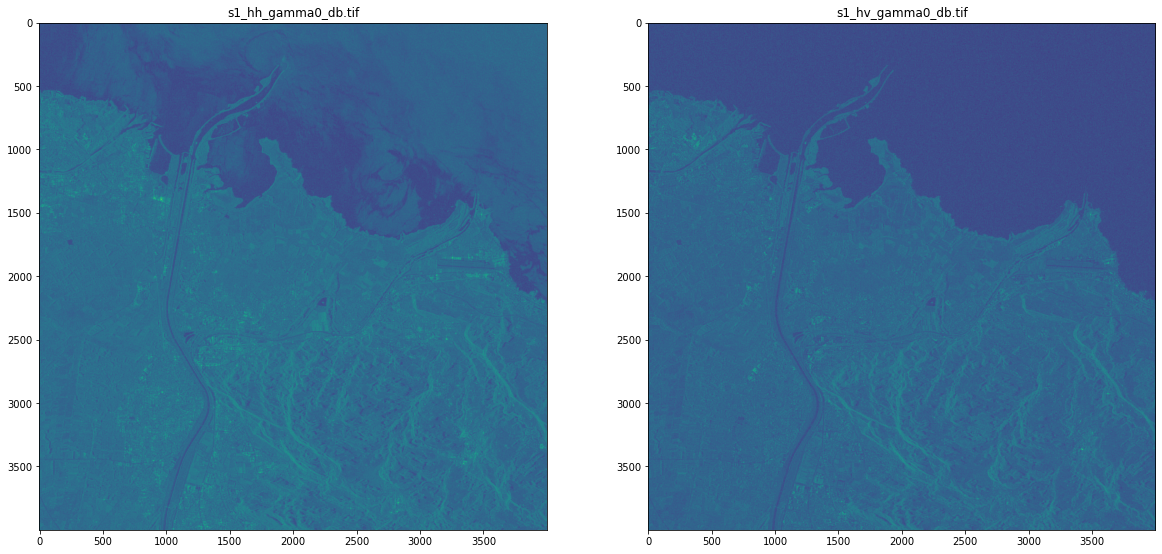

In [30]:
import matplotlib.pyplot as plt
import cv2

w = 10
h = 10
fig = plt.figure(figsize=(20, 10))
columns = 2
rows = 1
tiffs=["s1_hh_gamma0_db.tif","s1_hv_gamma0_db.tif"]
for i in range(1, columns*rows +1):
    img = cv2.imread("./"+tiffs[i-1], cv2.IMREAD_UNCHANGED)
    subPlot=fig.add_subplot(rows, columns, i)
    subPlot.set_title(tiffs[i-1])
    plt.imshow(img)
plt.show()


#### Geometry corrections 

We will use here the output of the radiometric calibration exercise (gamma0) as input.

Use the **Orthorectification** application to perform geometric corrections using S1 metadata from the
SLC product:

1. Without Digital Elevation Model (DEM)
2. With a DEM and a geoid (use the SRTM folder)
3. Compare the 2 images in Monteverdi.



 1. Orthorectification without DEM:

```
$ otbcli_OrthoRectification \
-io.in s1_hh_gamma0.tif \
-io.out s1_hh_gamma0_ortho.tif uint16
```

 2. With a DEM and a geoid:

```
$ otbcli_OrthoRectification \
-io.in s1_hh_gamma0.tif \
-io.out s1_hh_gamma0_ortho.tif uint16 \
-elev.dem SRTM/ \
-elev.geoid Geoid/egm96.grd
```

 3. Default projection is UTM. 32 North.

In [37]:
!otbcli_OrthoRectification \
    -io.in s1_hh_gamma0.tif \
    -io.out s1_hh_gamma0_ortho.tif uint16

2022-06-23 16:40:05 (INFO): Elevation management: setting default height above ellipsoid to 0 meters
2022-06-23 16:40:05 (INFO): Loading kwl metadata from attached geom file s1_hh_gamma0.geom
2022-06-23 16:40:05 (INFO): Elevation management: setting default height above ellipsoid to 0 meters
2022-06-23 16:40:05 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 16:40:05 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 16:40:05 (INFO): OTB will use at most 8 threads
2022-06-23 16:40:05 (INFO): Elevation management: setting default height above ellipsoid to 0 meters
2022-06-23 16:40:06 (INFO): Generating output with size = [4785, 4729]
2022-06-23 16:40:06 (INFO): Generating output with pixel spacing = [3.62923, -3.62923]
2022-06-23 16:40:06 (INFO): Generating output with origin = [539352, 5.26636e+06]
2022-06-23 16:40:06 (INFO): Area outside input image bounds will have a pixel value of [0]
2022-06-23 16:40:06 (INFO): Using a deformation grid with a physical spacing of 4
2022-06

With a DEM and a geoid:

In [41]:
!otbcli_OrthoRectification \
    -io.in s1_hh_gamma0.tif \
    -io.out s1_hh_gamma0_ortho1.tif uint16 \
    -elev.dem WorkshopData/sar/SRTM/ \
    -elev.geoid WorkshopData/sar/Geoid/egm96.grd

2022-06-23 16:43:26 (INFO): Elevation management: setting default height above ellipsoid to 0 meters
2022-06-23 16:43:26 (INFO): Loading kwl metadata from attached geom file s1_hh_gamma0.geom
2022-06-23 16:43:26 (INFO): Elevation management: setting default height above ellipsoid to 0 meters
2022-06-23 16:43:26 (INFO): Elevation management: setting default height above ellipsoid to 0 meters
2022-06-23 16:43:26 (INFO): Elevation management: using DEM directory (WorkshopData/sar/SRTM/)
2022-06-23 16:43:26 (INFO): Elevation management: setting default height above ellipsoid to 0 meters
2022-06-23 16:43:26 (INFO): Elevation management: using geoid file (WorkshopData/sar/Geoid/egm96.grd)
2022-06-23 16:43:26 (INFO): Elevation management: using DEM directory (WorkshopData/sar/SRTM/)
2022-06-23 16:43:27 (INFO): Default RAM limit for OTB is 128 MB
2022-06-23 16:43:27 (INFO): GDAL maximum cache size is 1600 MB
2022-06-23 16:43:27 (INFO): OTB will use at most 8 threads
2022-06-23 16:43:27 (INFO):

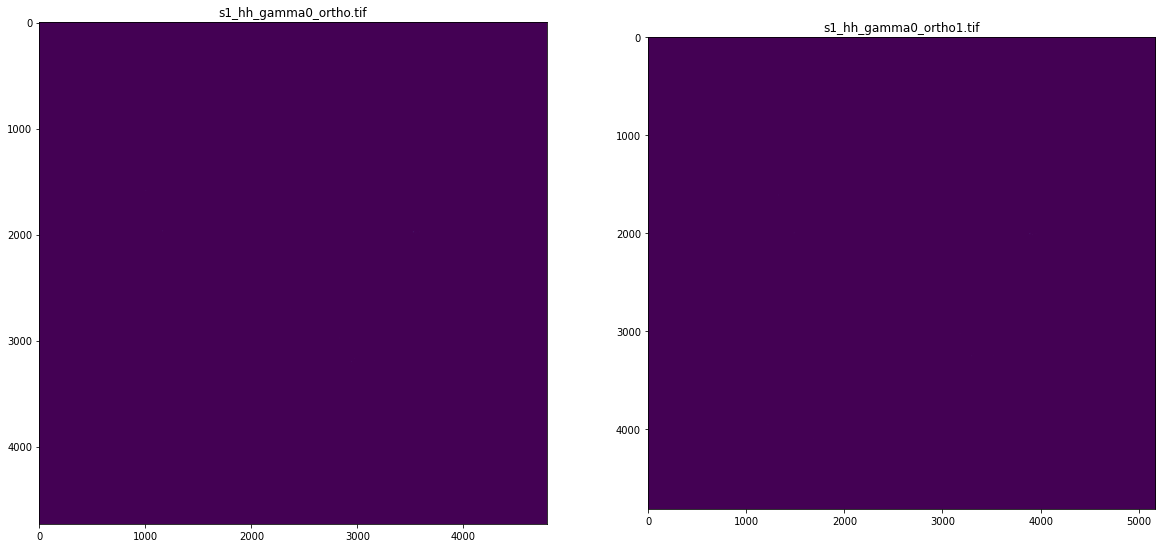

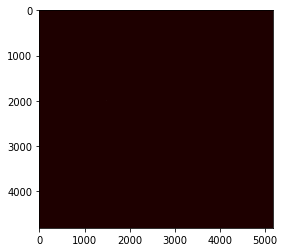

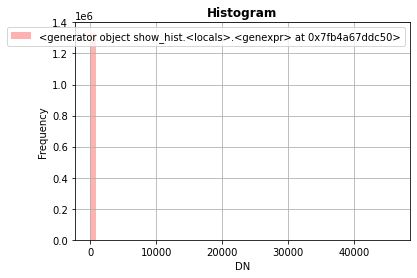

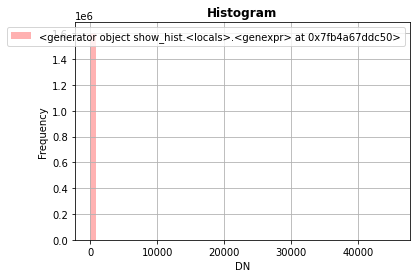

In [57]:
import matplotlib.pyplot as plt
import cv2
import rasterio
from rasterio.plot import show_hist

w = 10
h = 10
fig = plt.figure(figsize=(20, 10))
columns = 2
rows = 1
tiffs=["s1_hh_gamma0_ortho.tif","s1_hh_gamma0_ortho1.tif"]
for i in range(1, columns*rows +1):
    img = cv2.imread("./"+tiffs[i-1], cv2.IMREAD_UNCHANGED)
    subPlot=fig.add_subplot(rows, columns, i)
    subPlot.set_title(tiffs[i-1])
    plt.imshow(img)
plt.show()


import rasterio
from matplotlib import pyplot
pyplot.imshow(src.read(1), cmap='pink')
#pyplot.imshow(src.read(2), cmap='pink')


pyplot.show()

for i in range(1, columns*rows +1):
    src = rasterio.open(tiffs[i-1])
    show_hist(
        src, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")



#### Speckle filtering 

SAR images are affected by speckle noise that inherently exists in and which degrades
the image quality. It is caused by the coherent nature of backscattered waves from multiple distributed
targets. It is locally strong and it increases the mean grey level of a local area.

Several different methods are used to eliminate speckle noise, based upon different mathematical models of the phenomenon. In the following part we will use the Frost filter. This algorithm has 2 parameters:

* Radius: window radius
* deramp: controls the exponential function used to weight effect of the distance between the central
pixel and its neighborhood.


You can find more details about the Frost filter here.
1. What despeckle methods are available in OTB?
2. Use the Frost filter with different radiuses (3, 5 and 10) and comment about the effects on the output
image.
3. Compare the histogram of the filtered image with the one of the intensity?
4. Use the Frost filter with radius=5 and different deramp values (0.05, 0.2 and 0.8). Comment about
the effects of the deramp parameter.

#### Polarimetry

We will introduce basic notions of SAR polarimetry to show that HH and HV polarizations
allows to access different types of information.

1. Compute the difference between HH and HV (use the intensity images as input).
2. Create a color composite of bands HH, HV and HH-HV. We can take here 2*HV as HV backscattered
values are generally lower.
3. Convert the color composition into decibels (dB).
4. Display the image in Monteverdi and comment about the differences between HH and HV (layover
areas, vegetation, soil, water. . . )
5. Using the image which combines HH, HV and HH-HV in decibels try to find in the extract:
   * the coordinates of 2 parallel power lines;
   * harder to find, locate in the image an area which looks like a corner reflector (reflects waves
back directly towards the source);
   * what can you see in the lake at pixel coordinates (930,1170)?

#### Feature extraction 

To go further, we can explore available feature extractions methods for SAR available
in OTB.

See for instance Touzi filter in EdgeExtraction application.